# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [182]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from sklearn import metrics
from sklearn.neighbors import KDTree

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [183]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'

In [184]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    X = df.drop(['label'], axis=1)
    y = df.label
    # кодируем злокачественную опухль как 1, доброкачественную как 0
    y[y == 'M'] = 1
    y[y == 'B'] = 0
    return X.values, y.values

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    X = df.drop(['label'], axis=1)
    y = df.label
    return X.values, y.values

In [185]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

<ipython-input-184-ad1b8ddd9f36>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'M'] = 1
<ipython-input-184-ad1b8ddd9f36>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'B'] = 0


#### 2. (0.5 балла) 

Сначала реализуем скейлинг, тк он важен для моделей kNN и k-means. Будем использовать standard scaler.

In [186]:
def standard_scaler(X):
    X_scaled = X.copy()
    X_scaled = (X_scaled - X_scaled.mean()) / X_scaled.std()
    return X_scaled

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [187]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    
    size = X.shape[0]
    train_size = int(size * ratio)
    
    train_ids = np.random.choice(np.arange(size), size=train_size, replace=False)
    
    X_train = X[train_ids]
    y_train = y[train_ids]
    X_test = np.delete(X, train_ids, axis=0)
    y_test = np.delete(y, train_ids, axis=0)
    
    return X_train, y_train, X_test, y_test

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [188]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    
    classes = np.unique(y_true)
    
    precision = []
    recall = []
    accuracy = 0
    
    for c in classes:
        TP = 0
        FP = 0
        FN = 0
        TN = 0
        
        for i in range(len(y_true)):
            if c == y_true[i] and c == y_pred[i]:
                TP += 1
            elif c != y_true[i] and c == y_pred[i]:
                FP += 1
            elif c == y_true[i] and c != y_pred[i]:
                FN += 1
            elif c != y_true[i] and c != y_pred[i]:
                TN += 1
        
        if TP + FP == 0:
            precision.append(0)
        else:
            precision.append(TP / (TP + FP))
        
        if TP + FN == 0:
            recall.append(0)
        else:
            recall.append(TP / (TP + FN))
    
    accuracy = sum(y_pred == y_true) / len(y_true)
    
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [189]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [190]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [191]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.kdtree = None
        self.labels = None
        self.classes = None 
    
    def fit(self, X, y):
        self.kdtree = KDTree(X, leaf_size=self.leaf_size, metric='minkowski')
        self.labels = y.copy()
        self.classes = np.unique(y)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        dist, ind = self.kdtree.query(X, k=self.n_neighbors)
        
        result = []
        
        for i in ind:
            pred = self.labels[i]
            r = []
            for c in self.classes:
                r.append(sum(c == pred) / len(pred))
            result.append(r)
        
        return np.array(result)
        
    def predict(self, X):
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]


Наконец, протестируем наш классификатор на различных наборах данных

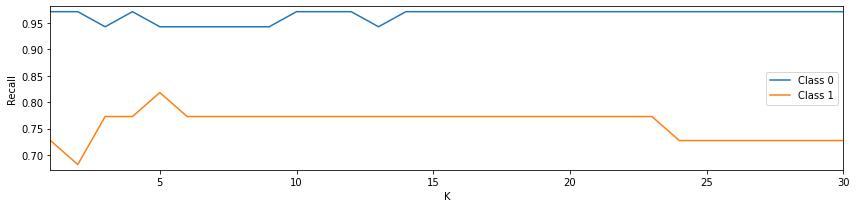

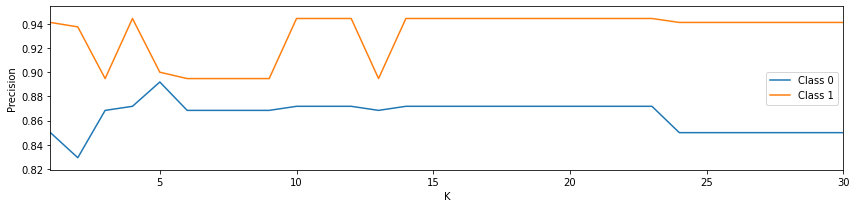

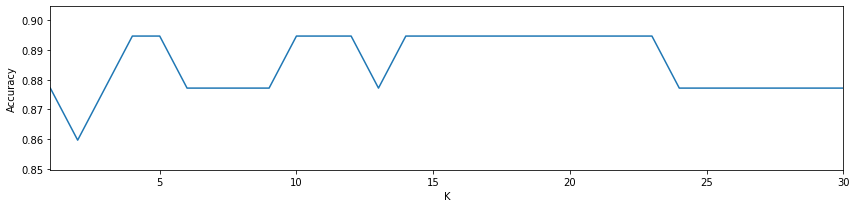

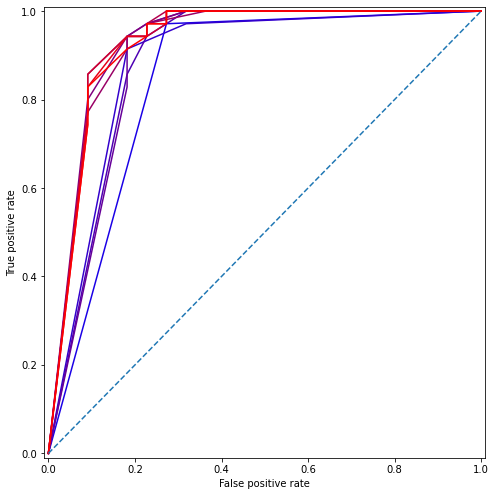

In [192]:
X_cancer_scaled = standard_scaler(X_cancer)
X_train, y_train, X_test, y_test = train_test_split(X_cancer_scaled, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

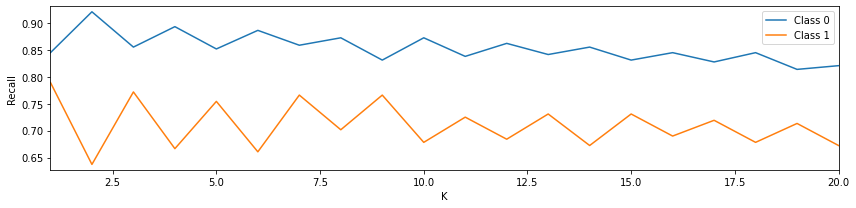

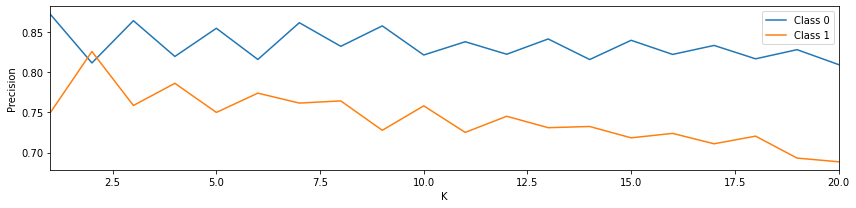

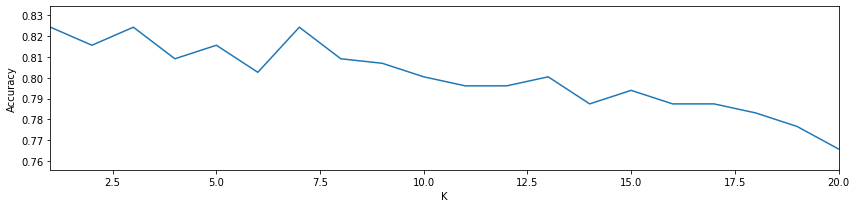

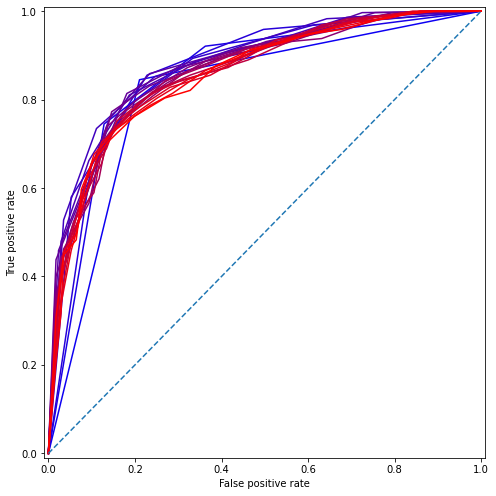

In [193]:
X_spam_scaled = standard_scaler(X_spam)
X_train, y_train, X_test, y_test = train_test_split(X_spam_scaled, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

Для данных по раку получили наиболее высокие результаты по метрикам precision и recall для класса 1 (злокачественная опухль) при k = 5. Accuracy также высокая для этого класса.
Выбор метрики для отражения качества модели зависит от задачи. Если нам важнее не пропустить злокачественную опухль, то важно обратить внимание на метрику precision для класса 1.

В случае со спапом наилучшие значения также достигаются при маленьких k (до 7).

Вообще классы достаточно сбалансированны, поэтому метрика accuracy также может использоваться для оценки.

Для оценки общего качества можели я бы использовал метрику AUC (площадь под кривой ROC)

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [371]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from scipy import ndimage
from scipy.cluster.vq import vq, kmeans, whiten

In [342]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

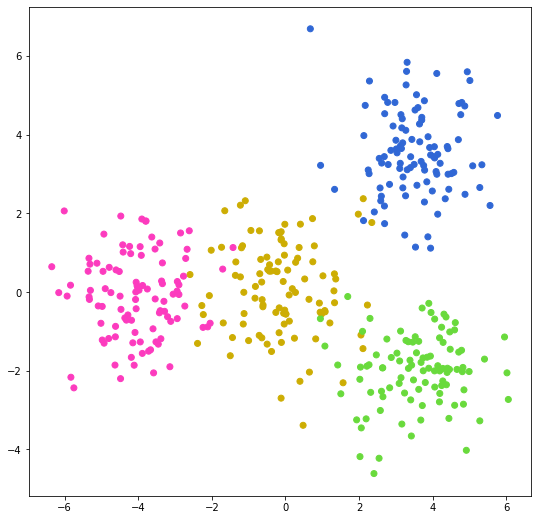

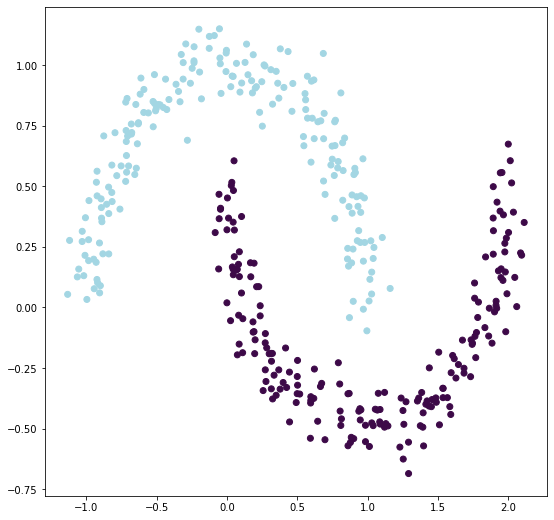

In [343]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [386]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        
    def fit(self, X, y=None):
        
        if self.init == "random":            
            self.centroids = np.random.rand(self.n_clusters, X.shape[1])
        elif self.init == "sample":
            ids = np.random.choice(np.arange(X.shape[0]), size=self.n_clusters, replace=False)
            self.centroids = X[ids]
        elif self.init == "k-means++":
            p = [1 / X.shape[0]] * X.shape[0]
            for _ in range(self.n_clusters - 1):
                ids = np.random.choice(np.arange(X.shape[0]), size=self.n_clusters, replace=False, p=p)
                self.centroids = X[ids]
                self.kdtree = KDTree(self.centroids)
                dist, ind = self.kdtree.query(X, k=1)
                M = dist.flatten() 
                M = M**2
                p = M / sum(M)
                    
        for _ in range(self.max_iter):
            self.kdtree = KDTree(self.centroids)
            dist, ind = self.kdtree.query(X, k=1)
                        
            clusters = [[] for _ in range(self.n_clusters)]
            for n, i in enumerate(ind):
                clusters[i[0]].append(X[n])
            
            for i, cl in enumerate(clusters):
                if len(cl) != 0:
                    self.centroids[i] = np.average(cl, axis=0)
        
        self.kdtree = KDTree(self.centroids)
        
    def predict(self, X):
        return self.kdtree.query(X, k=1)[1].flatten()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

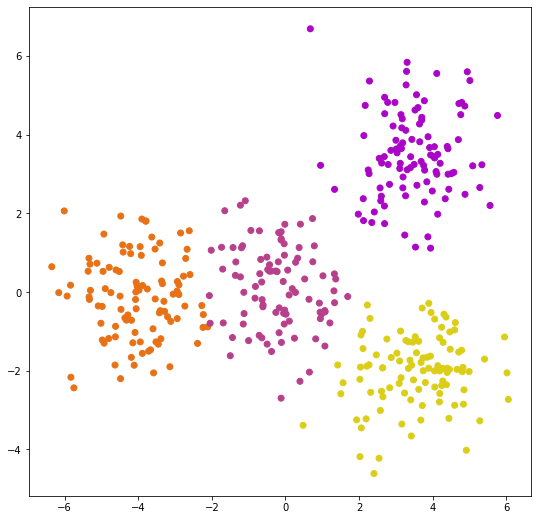

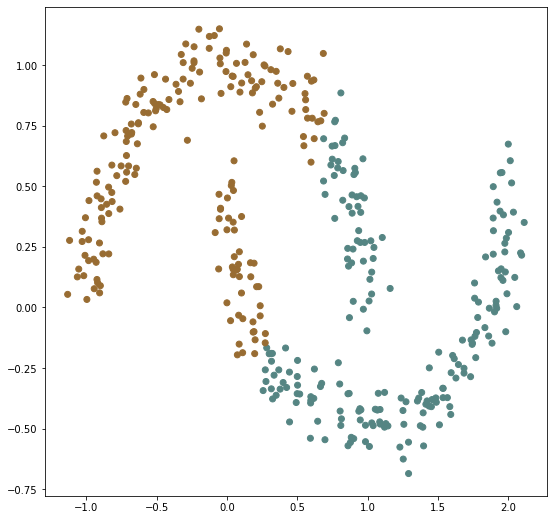

In [387]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

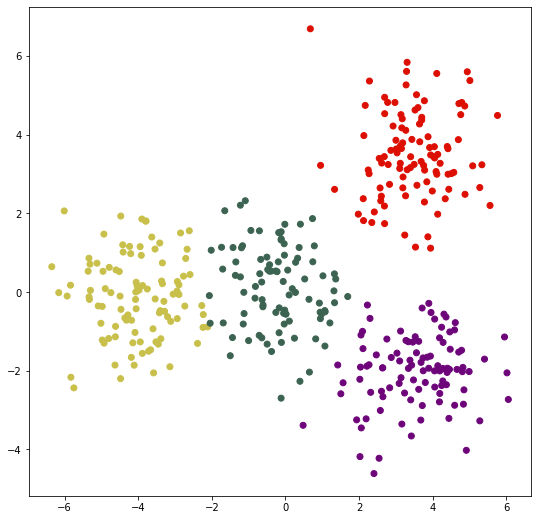

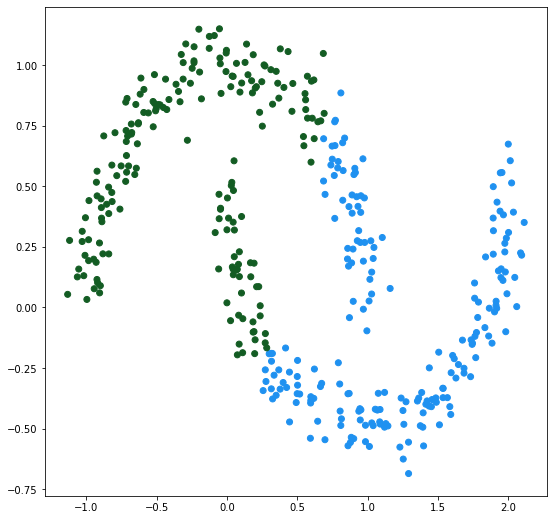

In [388]:
kmeans = KMeans(n_clusters=4, init='sample')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='sample')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

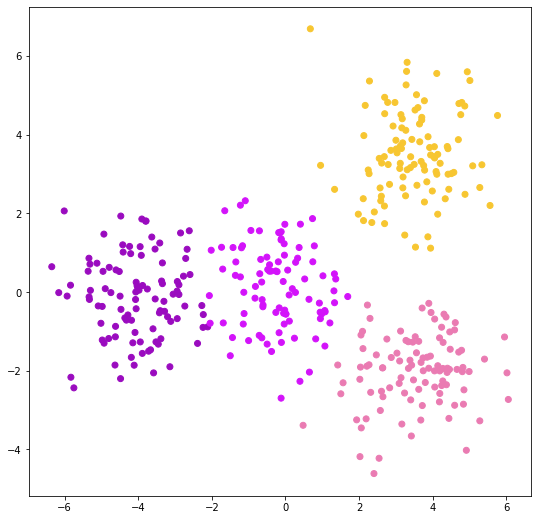

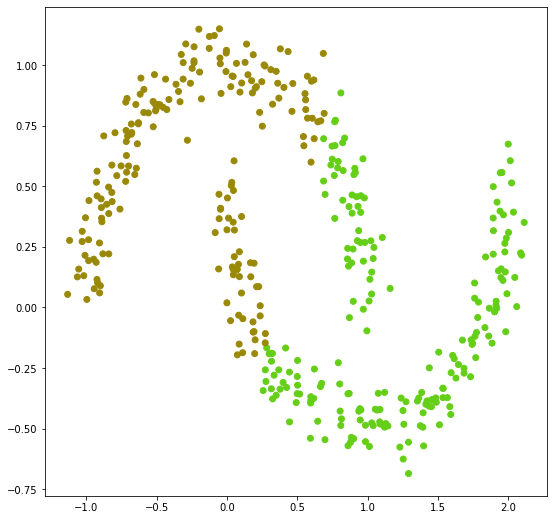

In [389]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [435]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        self.kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        ids = np.random.choice(np.arange(X.shape[0]), size=1, replace=False)[0]
        
        labels = [-1] * X.shape[0]
        
        C = 0
        
        for i, x in enumerate(X):
            if labels[i] == -1:
                ind = self.kdtree.query_radius(np.array([x]), r=self.eps)[0]
                ind = list(ind)
                if len(ind) < self.min_samples:
                    labels[i] = -2
                else:
                    labels[i] = C
                    for s in ind:
                        if labels[s] != -1:
                            continue
                        labels[s] = C
                        new_ind = self.kdtree.query_radius(np.array([X[s]]), r=self.eps)[0]
                        new_ind = list(new_ind)
                        if len(new_ind) >= self.min_samples:
                            for n in new_ind:
                                if n not in ind:
                                    ind.append(n)
                    C += 1
        
        N = max(labels) + 1
        
        for i in range(len(labels)):
            if labels[i] == -2:
                labels[i] = N
        
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

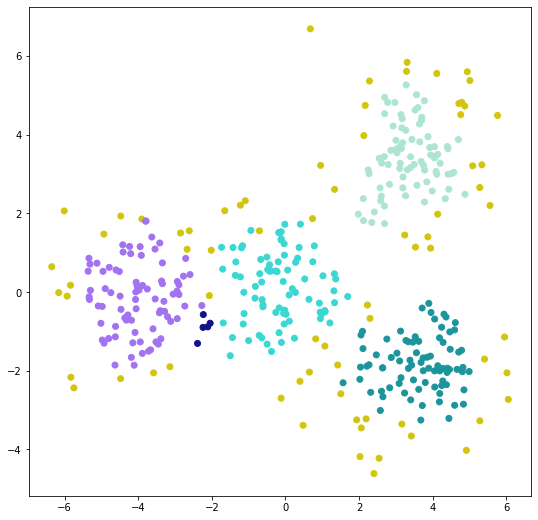

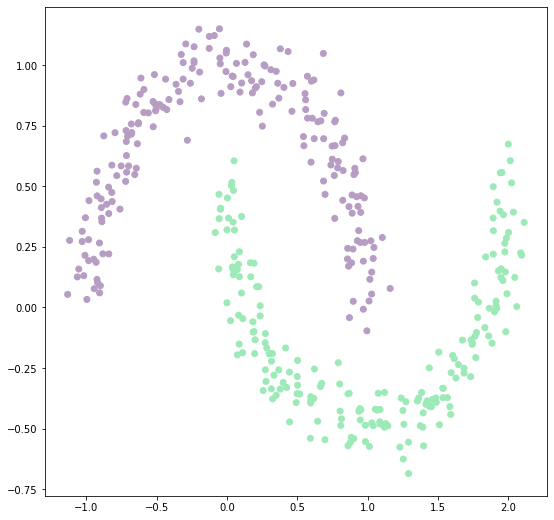

In [441]:
dbscan = DBScan(eps=0.5)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

In [443]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [447]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
print('X1, davies_bouldin_score, k-means', davies_bouldin_score(X_1, labels))
print('X1, silhouette_score, k-means', silhouette_score(X_1, labels))

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
print('X2, davies_bouldin_score, k-means', davies_bouldin_score(X_2, labels))
print('X2, silhouette_score, k-means', silhouette_score(X_2, labels))

dbscan = DBScan(eps=0.5)
labels = dbscan.fit_predict(X_1)
print('X1, davies_bouldin_score, dbscan', davies_bouldin_score(X_1, labels))
print('X1, silhouette_score, dbscan', silhouette_score(X_1, labels))

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
print('X2, davies_bouldin_score, dbscan', davies_bouldin_score(X_2, labels))
print('X2, silhouette_score, dbscan', silhouette_score(X_2, labels))

X1, davies_bouldin_score, k-means 0.5947679864896678
X1, silhouette_score, k-means 0.567101144379956
X2, davies_bouldin_score, k-means 0.7828359126528807
X2, silhouette_score, k-means 0.483502503029707
X1, davies_bouldin_score, dbscan 2.31536471760873
X1, silhouette_score, dbscan 0.29074277796173403
X2, davies_bouldin_score, dbscan 1.1630310398087622
X2, silhouette_score, dbscan 0.32617317547968405


Davies-Bouldin index показывает меньшие значения для k-means, значит качество кластеризации выше

silhouette_score больше также для k-means, что также указывает на лучшее качество кластеризации

### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [18]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [21]:
# YOUR_CODE